In [14]:
import time
import sys
from datetime import datetime
from pathlib import Path
from os import listdir
from os.path import isfile, join

import numpy as np
import cv2
from PIL import Image

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from ahds import AmiraFile

In [22]:
def read_amira_volume(amira_file_name):
    
    af = AmiraFile(amira_file_name, load_streams=False)
    header_length = af.meta.header_length

    #print(af)
    #print('Header length', header_length)

    w = af.header.Lattice.length[0]
    h = af.header.Lattice.length[1]
    d = af.header.Lattice.length[2]
    
    start = time.time()

    data = np.fromfile(amira_file_name, dtype=np.uint8, count=-1, offset=header_length+5)

    #print(w*h*d)
    #print(len(data))
    data = data.reshape((d, h, w))

    end = time.time()
    print(f'Read time:{end-start}')
    
    return data


def read_amira_labels(amira_file_name):
    start = time.time()
    af = AmiraFile(amira_file_name, load_streams=True)
    header_length = af.meta.header_length
    labels = af.data_streams.Labels.data
    
    end = time.time()
    print(f'Read time:{end-start}')
    
    return labels

def get_extents(volume):
    z,y,x = np.where(volume != 0)
    
    return (np.min(z), np.max(z)), (np.min(y), np.max(y)), (np.min(x), np.max(x))


def save_np_sequence_as_multitiff_stack(images, file_name):
    
    imlist = []
    for i in range(len(images)):
        imlist.append(Image.fromarray(images[i]))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])
    
    del imlist    
    
def save_np_as_multitiff_stack(volume, file_name):
    
    imlist = []
    for i in range(volume.shape[0]):
        imlist.append(Image.fromarray(volume[i]))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])
    
    del imlist 

In [6]:
data_path = Path('../unet-pytorch/data')

In [7]:
vol = read_amira_volume(data_path / '746_8bit0000.am')

Using pattern: b'(?:^|\n)@(?P<stream>\\d+)\n'


Elapsed:3.3312289714813232


In [10]:
label = read_amira_labels(data_path / '746_8bit0000.tif-labels.am')

Using pattern: b'(?:^|\n)@(?P<stream>\\d+)\n'


Read time:4.199636936187744


In [23]:
ext = get_extents(label)

In [24]:
ext

((3357, 3632), (754, 1137), (588, 891))

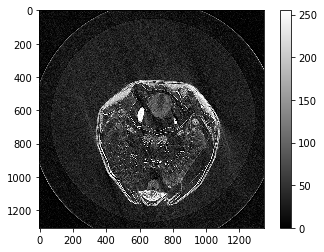

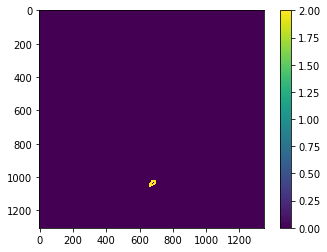

In [25]:
im = vol[ext[0][1],:,:]
plt.imshow(im, cmap='gray')
plt.colorbar()
plt.show()

im = label[ext[0][1],:,:]
plt.imshow(im)
plt.colorbar()
plt.show()

In [27]:
z0 = ext[0][0]
z1 = ext[0][1]
y0 = ext[1][0]
y1 = ext[1][1]
x0 = ext[2][0]
x1 = ext[2][1]

crop = vol[z0:z1, y0:y1, x0:x1]
save_np_as_multitiff_stack(crop, 'data/crop.tif')

crop = label[z0:z1, y0:y1, x0:x1]
save_np_as_multitiff_stack(crop, 'data/crop_labels.tif')